# Algotytm przecinania się odcinków na płaszczyźnie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.tests.test4 import Test
from bitalg.visualizer.main import Visualizer

# Przydatne funkcje 

In [53]:
np.random.seed(100)

def draw_example_1():
    # TODO narysowac to uzywając naszego narzędzia do wizualizacji
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))

    vis.add_line_segment(line_segments)
    vis.show()
    
def draw_example_2():
    # TODO narysowac to uzywając naszego narzędzia do wizualizacji
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))
    points = [(4, 2),
              (2.5, 3.5),
              (5.5, 4.5)]

    vis.add_line_segment(line_segments)
    vis.add_point(points, color='red')
    vis.show()

def draw_segments(lines):
    vis = Visualizer()
    vis.add_line_segment(lines)
    vis.show()

def draw_intersecitons(segments, intersections):
    vis = Visualizer()
    vis.add_line_segment(segments)
    points = [i[0] for i in intersections]
    vis.add_point(points)
    vis.show()



### Wprowadzenie
Celem ćwiczenia jest implementacja i zapoznanie się z algorytmem wyznaczającym wszystkie przecięcia się odcinków na płaszczyźnie

### Przykładowy zbiór odcinków przed wyznaczeniem punktów przecięcia

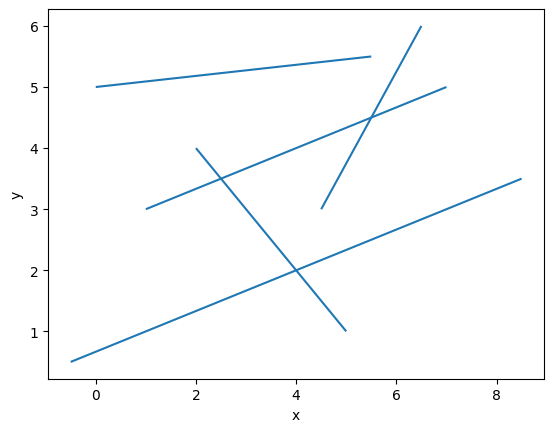

In [3]:
draw_example_1()

### Przykładowy zbiór odcinków po wyznaczenu punktów przecięcia

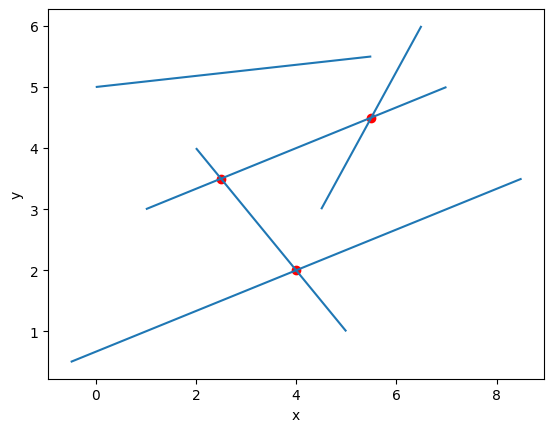

In [4]:
draw_example_2()

# Generowanie losowych odcinków na płaszczyźnie

Uzupełnij funkcję ```generate_uniform_sections```

In [5]:
def generate_uniform_sections(max_x, max_y, n):
    """
    Funkcja generuje odcinki o współrzędnych rzeczywistych w postaci par punktów. 
    Żaden wygenerowany odcinek nie jest odcinkiem pionowym.
    Żadne dwa odcinki nie mają swoich końców o takiej samej współrzędnej x.
    Zakres współrzędnych: x -> (0, max_x), y -> (0, max_y)
    :param max_x: określa maksymalną wartość współrzednej x jaka może zostać wylosowana
    :param max_y: określa maksymalną wartość współrzednej y jaka może zostać wylosowana
    :param n: ilość generowanych odcinków
    :return: tablica odcinków w postaci krotek zawierających parę krotek współrzędnych punktów końcowych odcinków
    np. [((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)),...]
    """
    res = []
    for _ in range(n):
        x1 = np.random.uniform(0, max_x)
        x2 = np.random.uniform(0, max_x)
        y1 = np.random.uniform(0, max_y)
        y2 = np.random.uniform(0, max_y)
        res.append(((x1, y1), (x2, y2)))
    return res

In [6]:
Test().runtest(1, generate_uniform_sections)

Lab 4, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.109s


<span style="color:red">Ćw.</span> Wygeneruj $\large20$ losowych odcinków w przestrzeni 2D o współrzędnych z przedziału $\large x \in \langle 0,1000 \rangle$ oraz $\large y \in \langle 0,1000\rangle$. 

In [7]:
section = generate_uniform_sections(1000, 1000, 20)

Zwizualizuj otrzymane odcinki

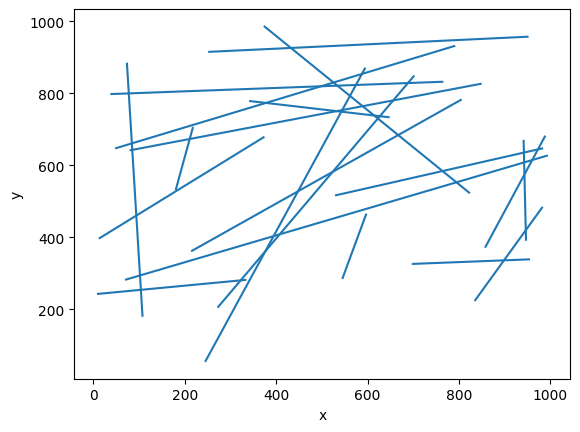

In [8]:
draw_segments(section)

Uzupełnij funkcję ```add_sections``` #interaktywne dodawanie odcinków przez rysowanie myszką (jak?) TODO

In [9]:
def add_sections(n):
    '''
Żeby skorzystać z graficznego wprowadzania odcinków należy wywołać funkcję `draw_app` z argumentem, 
który oznacza liczbę prostych. Wynik można zapisać do zmiennej,
np: `sections = draw_app(10)`.
'''
    %matplotlib tk
    clicks = []

    def onclick(event):
        x = event.xdata
        y = event.ydata
        if x is not None and y is not None:
            clicks.append((x, y))

    res = []
    fig, ax = plt.subplots(figsize = (7,7))
    plt.grid(True)
    plt.axis('equal')
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    while len(clicks) == 0:
        plt.pause(0.1)
    while len(clicks) == 1:
        plt.pause(0.1)
        plt.scatter(clicks[-1][0], clicks[-1][1], marker='o', color="red")

    while len(clicks)<2 * n:
        plt.pause(0.1)
        plt.scatter(clicks[-1][0], clicks[-1][1], marker='o', color="red")
        if len(clicks) % 2 == 0: 
            plt.plot((clicks[-1][0], clicks[-2][0]), (clicks[-1][1], clicks[-2][1]),color="blue")
            res.append(((clicks[-1][0], clicks[-1][1]), (clicks[-2][0], clicks[-2][1])))

    plt.pause(1)
    plt.close('all')
    %matplotlib inline
    return res

In [51]:
sections = add_sections(3)

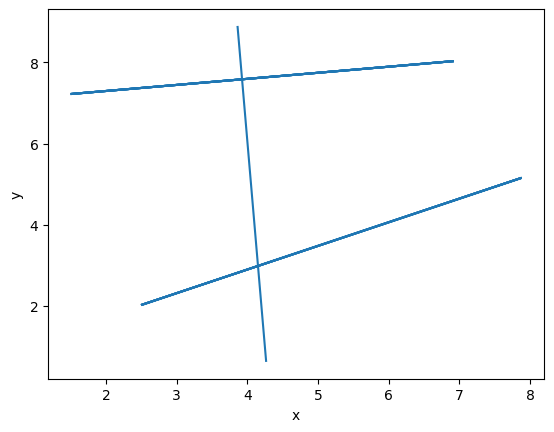

In [52]:
draw_segments(sections)

Uzupełnij funkcję ```is_intersection```

In [25]:
class Event:
    def __init__(self, point, segment, event_type):
        self.point = point
        self.segment = segment
        self.event_type = event_type

In [30]:
def is_intersecting(seg1, seg2):
    def orientation(p, q, r):
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        if val == 0:
            return 0  # Collinear
        return 1 if val > 0 else 2  # Clockwise or counterclockwise

    def on_segment(p, q, r):
        return q[0] <= max(p[0], r[0]) and q[0] >= min(p[0], r[0]) and q[1] <= max(p[1], r[1]) and q[1] >= min(p[1], r[1])

    o1 = orientation(seg1[0], seg1[1], seg2[0])
    o2 = orientation(seg1[0], seg1[1], seg2[1])
    o3 = orientation(seg2[0], seg2[1], seg1[0])
    o4 = orientation(seg2[0], seg2[1], seg1[1])

    if o1 != o2 and o3 != o4:
        return True  # General case - segments intersect

    if o1 == 0 and on_segment(seg1[0], seg2[0], seg1[1]):
        return True  # seg2[0] lies on seg1

    if o2 == 0 and on_segment(seg1[0], seg2[1], seg1[1]):
        return True  # seg2[1] lies on seg1

    if o3 == 0 and on_segment(seg2[0], seg1[0], seg2[1]):
        return True  # seg1[0] lies on seg2

    if o4 == 0 and on_segment(seg2[0], seg1[1], seg2[1]):
        return True  # seg1[1] lies on seg2

    return False  # No intersection


In [31]:
def is_intersection(sections):
    """
    Funkcja sprawdepsilonza czy jakakolwiek para podanych odcinków się przecina 
    :param sections: tablica odcinków w postaci krotek krotek współrzędnych punktów końcowych odcinków
    :param eps:  będący dokładnością, z jaką porównujemy liczby zmiennoprzecinkowe
    :return: True / False
    """
    events = []
    
    for segment in sections:
        events.append(Event(segment[0], segment, "start"))
        events.append(Event(segment[1], segment, "end"))

    # Sortowanie zdarzeń według współrzędnych x
    events.sort(key=lambda e: e.point[0])

    active_segments = []

    for event in events:
        if event.event_type == "start":
            active_segments.append(event.segment)
            active_segments.sort(key=lambda seg: seg[0][1])  # Sortowanie aktywnych odcinków według współrzędnych y
            idx = active_segments.index(event.segment)

            # Sprawdzanie przecięć z poprzednim i następnym odcinkiem w posortowanej kolejności
            if idx > 0 and is_intersecting(active_segments[idx - 1], event.segment):
                return True

            if idx < len(active_segments) - 1 and is_intersecting(event.segment, active_segments[idx + 1]):
                return True

        elif event.event_type == "end":
            active_segments.remove(event.segment)


    return False

In [32]:
Test().runtest(2, is_intersection)

Lab 4, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.001s


### W jaki sposób zaimplementowałeś struktura stanu (stan miotły) oraz struktura zdarzeń w Twoim programie?

Odpowiedź here

Uzupełnij funkcję ```is_intersection_with_visualization```

In [ ]:
def is_intersection_with_visualization(sections): # TODO wizualizacja (jak?)
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: True / False
    """
    raise Exception("Unimplemented")

Uzupełnij funkcję ```find_intersections```

In [48]:
def intersection_point(seg1, seg2):
    x1, y1 = seg1[0]
    x2, y2 = seg1[1]
    x3, y3 = seg2[0]
    x4, y4 = seg2[1]
    # Calculate determinants
    # print(x1, x2, x3, x4, y1, y2, y3, y4)
    det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)

    # Calculate parameters for the parametric equations
    t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / det
    u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / det

    # Check if the intersection point lies within both segments
    if 0 <= t <= 1 and 0 <= u <= 1:
        intersection_x = x1 + t * (x2 - x1)
        intersection_y = y1 + t * (y2 - y1)
        return (intersection_x, intersection_y)
    else:
        return None  # Intersection point is outside the segments


In [49]:
def find_intersections(sections):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """
    events = []
    for segment in sections:
        events.append(Event(segment[0], segment, "start"))
        events.append(Event(segment[1], segment, "end"))

    # Sortowanie zdarzeń według współrzędnych x
    events.sort(key=lambda e: e.point[0])

    active_segments = []
    intersections = []

    for event in events:
        # print(event.segment)
        if event.event_type == "start":
            active_segments.append(event.segment)
            active_segments.sort(key=lambda seg: seg[0][1])  # Sortowanie aktywnych odcinków według współrzędnych y
            idx = active_segments.index(event.segment)

            # Sprawdzanie przecięć z poprzednim i następnym odcinkiem w posortowanej kolejności
            if idx > 0 and is_intersecting(active_segments[idx - 1], event.segment):
                id1 = sections.index(event.segment)
                id2 = sections.index(active_segments[idx-1])
                intersections.append((intersection_point(event.segment, active_segments[idx-1]), id1, id2))

            if idx < len(active_segments) - 1 and is_intersecting(event.segment, active_segments[idx + 1]):
                id1 = sections.index(event.segment)
                id2 = sections.index(active_segments[idx+1])
                intersections.append((intersection_point(event.segment, active_segments[idx+1]), id1, id2))

        elif event.event_type == "end":
            active_segments.remove(event.segment)

        # Możesz dodać obsługę zdarzenia "intersection" w przypadku wykrycia przecięcia

    return intersections

In [58]:
Test().runtest(3, find_intersections)

Lab 4, task 3:
	Test 1: WRONG ANSWER
		Output:   [((-0.0016743790516658072, -0.007263586832941066), 1, 0), ((0.011860591253227503, -0.018140143229495413), 2, 0), ((0.022658670631229855, -0.026817363547212175), 3, 0)]
		Expected: ['-0.0016743790516658117 -0.007263586832941072 1 2', '0.011526074740254208 0.006132801296422439 2 3', '0.011860591253227505 -0.018140143229495424 1 3', '0.022344451130778698 0.01711175484919488 2 4', '0.022658670631229855 -0.026817363547212168 1 4']
	Test 2: WRONG ANSWER
		Output:   [((0.01333259118334631, -0.01619339562692305), 3, 2)]
		Expected: ['0.005806934807635715 -0.016556444720678153 2 3', '0.010025601838031018 -0.020988202988542273 2 4', '0.013332591183346312 -0.01619339562692305 3 4']
	Test 3: Passed
Result: 1/3
Time: 0.002s


Uzupełnij funkcję ```find_intersections_with_visualization```

In [ ]:
def find_intersections_with_visualization(sections): # TODO wizualizacja (jak?)
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """

### Czy konieczne były zmiany w strukturze zdarzeń. Jeśli tak, to jakie? Czy w przypadku obu algorytmów konieczne są takie same struktury zdarzeń?
### Odpowiedź uzasadnij. 

Odpowiedź here

### Jak obsługiwane są zdarzenia początku odcinka, końca odcinka i przecięcia odcinków z uwzględnianiem wybranych struktur danych?

Odpowiedź here

### Samemu zaprojektuj test, który uwzględnia taki układ odcinków, przy którym pewne przecięcia będą wykrywane więcej niż jeden raz

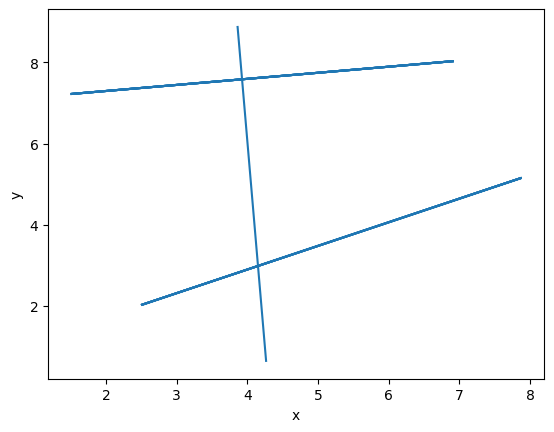

In [56]:
draw_segments(sections)

In [57]:
find_intersections(sections)

ValueError: list.remove(x): x not in list

In [ ]:
# testing_sections = ???

In [ ]:
### Czy Twój program uwzględnia powyższy przypadek? Jeśli tak, to jak? 

Odpowiedź here

### Zadanie dodatkowe
Zaimplementuj inną strukturę stanu. Opisz ją w sprawozdaniu. Porównaj efektywność algorytmu dla obu struktur robiąc testy na odpowiednio dużych zestawach odcinków.